In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# filter only test playersex
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = 10

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

10

In [25]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,519317,0.974327,56.177043,13.693746,64.166667,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1989-11-08,2010-06-08,USA,111.13004,Designated Hitter,1.9812,28.312279
1,519317,0.743145,31.715912,11.397756,47.248120,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1989-11-08,2010-06-08,USA,111.13004,Designated Hitter,1.9812,28.312279
2,519317,0.741518,30.998168,25.975685,79.879622,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1989-11-08,2010-06-08,USA,111.13004,Designated Hitter,1.9812,28.312279
3,519317,0.434217,40.828745,6.552563,86.740331,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1989-11-08,2010-06-08,USA,111.13004,Designated Hitter,1.9812,28.312279
4,519317,1.700575,20.981956,26.427778,34.202094,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1989-11-08,2010-06-08,USA,111.13004,Designated Hitter,1.9812,28.312279


### preprocessing with pipelines

In [26]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info
from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [27]:
inplace_ffill_features = ['numberOfFollowers',
                          'teamFollowers',
                          'status',
                          'teamId',
                          'rosterDate',
                          'pstatsDate']

In [28]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features,
                                                        'on': ['playerId', 'year']})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [29]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('hardcoded_feat', harcoded_feat_tmf)])

In [30]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [31]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName',
              'status', 'teamId', 'weekday',
              'opponentTeamId', 'birthCountry']

In [32]:
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [33]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[30], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


target_stats_table.head()

,playerId,date,target1__mean__30d,target1__median__30d,target1__std__30d,target2__mean__30d,target2__median__30d,target2__std__30d,target3__mean__30d,target3__median__30d,target3__std__30d,target4__mean__30d,target4__median__30d,target4__std__30d
0,519317,2018-01-01,0.974327,0.974327,NaN,56.177044,56.177044,NaN,13.693746,13.693746,NaN,64.166664,64.166664,NaN
1,519317,2018-01-02,0.858736,0.858736,0.163470,43.946476,43.946476,17.296631,12.545751,12.545751,1.623510,55.707394,55.707394,11.963219
2,519317,2018-01-03,0.819663,0.743145,0.133945,39.630375,31.715912,14.334328,17.022396,13.693746,7.838299,63.764801,64.166664,16.319462
3,519317,2018-01-04,0.723302,0.742332,0.221592,39.929966,36.272327,11.719257,14.404937,12.545751,8.268230,69.508682,72.023148,17.593142
4,519317,2018-01-05,0.918756,0.743145,0.477326,36.140366,31.715912,13.221618,16.809505,13.693746,8.954467,62.447369,64.166664,21.941971


In [34]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[45], clip_max=True)),
                                 ('fillnan', FunctionTransformer(fillna)),
                                 ('normalize', PdScaleNorm())
                                ])

In [35]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [36]:
from pipeline.core import FilterFeatures

In [37]:
player_tv_cont_features = FilterFeatures(['runsScored__ptvf', 'homeRuns__ptvf',
                                          'hits__ptvf', 'SLG__ptvf',
                                          'rbi__ptvf',
                                          'plateAppearances__ptvf',
                                          'runsPitching__ptvf',
                                           'playerId', 'date']).fit(df)._features

In [38]:
player_tv_cont_features

['playerId',
 'date',
 'runsScored__ptvf',
 'homeRuns__ptvf',
 'hits__ptvf',
 'plateAppearances__ptvf',
 'rbi__ptvf',
 'runsPitching__ptvf',
 'SLG__ptvf']

In [39]:
## moving stats for players stats
# get the rest of the continuous features
stats_gen_cont_features = StatisticGen(stats=['sum', 'max'],
                             windows=[7],
                             drop_index=True)
_mov_cont_feat_tmf = Pipeline([('fillnan', FunctionTransformer(fillna)),
                               ('cont_stats', stats_gen_cont_features),
                                ('normalize', PdScaleNorm()),
                                ])
mov_cont_feat_tmf = PdColumnTransformer([('cont', _mov_cont_feat_tmf, player_tv_cont_features)]
                                 )

In [40]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                   ('cats', categories_tmf),
                                   ('mov_feat', mov_cont_feat_tmf),
                                  ])

In [41]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [42]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7f5bb0e39940>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

In [43]:
from data.split import SplitData

In [44]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-04-01", test_days=500)

In [45]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [46]:
%%time
# train the pipeline only with the train dataset
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 354 ms


Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7f5bb0e39940>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

In [47]:
# def add_noise(df: pd.DataFrame, features,
#               on):
#     noise_std = df.groupby(['playerId'])[features].transform('std')
#     noisy_features = (np.random.randn(*noise_std.shape) * noise_std).to_numpy().astype(np.float32)
    
#     return noisy_features

In [48]:
# noise_df = df.copy()

In [49]:
# noise_df.loc[train_idx, target_cols] += add_noise(noise_df.loc[train_idx, :],
#                                            features=target_cols, on=['playerId'])

In [50]:
# noise_df.loc[train_idx, target_cols] = np.clip(noise_df.loc[train_idx, target_cols], 0, 100)

In [51]:
%%time
# transform all dataset
features = pipeline.transform(df)

CPU times: user 318 ms, sys: 0 ns, total: 318 ms
Wall time: 316 ms


In [52]:
pd.options.display.max_rows = len(features.columns)
features.T.head(len(features.columns))

,0,1,2,3,4,5,6,7,8,9,...,12930,12931,12932,12933,12934,12935,12936,12937,12938,12939
target1__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.447754,0.392090,0.379639,0.382812,0.439941,0.500977,0.515625,0.520020,0.502441,0.508789
target1__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.231079,0.231079,0.197266,0.213745,0.213745,0.213745,0.226807,0.226807,0.216675,0.263672
target1__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.687500,0.594727,0.595703,0.594727,0.688477,0.763672,0.761719,0.761719,0.762695,0.758789
target2__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.274902,0.272705,0.276367,0.280273,0.304688,0.323486,0.340088,0.343262,0.348877,0.361084
target2__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.208984,0.208984,0.208984,0.215332,0.215332,0.246582,0.277344,0.277344,0.285400,0.304443
target2__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.443604,0.440918,0.442627,0.443604,0.559570,0.593262,0.609375,0.610840,0.613281,0.619141
target3__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.174194,0.148682,0.147461,0.143921,0.165283,0.200439,0.212891,0.222046,0.234741,0.242798
target3__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035797,0.035797,0.032837,0.016312,0.032837,0.051910,0.056854,0.056854,0.056854,0.068481
target3__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.630371,0.570312,0.571289,0.573730,0.603027,0.691406,0.690918,0.692871,0.700195,0.694824
target4__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.357666,0.333252,0.317627,0.307129,0.316650,0.315918,0.322754,0.315186,0.309570,0.323486


In [53]:
### box-cox transformation

In [54]:
from sklearn.preprocessing import PowerTransformer

In [55]:
class MLBPowerTransformer(PowerTransformer):
    def _fit(self, X, y, force_transform=False):
        return super()._fit(X + 1, y, force_transform=False)
    
    def transform(self, X):
        return super().transform(X + 1)
    
    def inverse_transform(self, X):
        return super().inverse_transform(X) - 1

In [56]:
scaled_cols = [f + '__scaled' for f in target_cols]
power_tmf = MLBPowerTransformer(method='box-cox')

In [57]:
# change the dtypes of the target (pytorch likes float32 and not float64)
df[target_cols] = df[target_cols].astype(np.float32)

# change the dtypes of the target (pytorch likes float32 and not float64)
df[scaled_cols] = power_tmf.fit_transform(df[target_cols]).astype(np.float32)

In [58]:
train_idx.shape

(12940,)

In [59]:
train_idx.shape

(12940,)

In [60]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [61]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [62]:
train_data.shape, raw_train_df.shape

((11860, 136), (11860, 121))

In [63]:
valid_data.shape, raw_valid_df.shape

((1080, 136), (1080, 121))

In [64]:
# add the target to features ds
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

In [65]:
train_data[scaled_cols] = power_tmf.transform(train_data[target_cols]).astype(np.float32)
valid_data[scaled_cols] = power_tmf.transform(valid_data[target_cols]).astype(np.float32)

### modeling 

In [66]:
target_features = list(features.columns[features.columns.str.startswith('target')])

In [67]:
new_categories = categories #+ #target_features

In [68]:
cont_features = features.columns.drop(new_categories).to_list()

In [69]:
new_categories

['playerId',
 'seasonPart',
 'year',
 'primaryPositionName',
 'status',
 'teamId',
 'weekday',
 'opponentTeamId',
 'birthCountry']

In [73]:
from omegaconf import OmegaConf
hp = {'epochs': 10,
      'batch_size': 512,
      'max_emb_sz': 20,
      'encoder_dim': 512,
      'depth': 2,
      'emb_dropout': 0.2,
      'dropout': 0.2,
      'decrease_factor': 0.5,
      'drop_decrease_factor': 1.,
      'lr': 0.001,
      'wd': 3e-5, 
      'scale_output': False}

real_data_config = {'hp': hp,
                    'seed': 2021,
         'features': cont_features,
          'categories': new_categories,
          'target_cols': scaled_cols}
real_data_config = OmegaConf.create(real_data_config)

In [74]:
from train import cont_emb_stack

In [75]:
output = cont_emb_stack.run_fn(real_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 385   
1 | output_layer | Sequential     | 213 K 
------------------------------------------------
213 K     Trainable params
0         Non-trainable params
213 K     Total params
0.855     Total estimated model params size (MB)


EmbModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.2, inplace=False)
    (emb): ModuleDict(
      (playerId): Embedding(10, 4)
      (seasonPart): Embedding(7, 3)
      (year): Embedding(4, 2)
      (primaryPositionName): Embedding(5, 3)
      (status): Embedding(8, 3)
      (teamId): Embedding(13, 4)
      (weekday): Embedding(7, 3)
      (opponentTeamId): Embedding(33, 6)
      (birthCountry): Embedding(3, 2)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=157, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

loading model to best score
best score = 0.6601150035858154


In [76]:
from train.core import Ensemble, predict_recursive
ensemble = Ensemble([output], pipeline)

In [77]:
# %%time
# raw_train_fr = raw_train_df[df.columns].copy()

# recursive_prediction = []
# for date, val_date_df in raw_valid_df.groupby('date'):
#     val_date_df = val_date_df[df.columns].reset_index(drop=True)
#     _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
#                                                      raw_train_fr,
#                                                      ensemble,
#                                                      n_days=90 + 60 + 10,
#                                                      target_cols=target_cols)
#     recursive_prediction.append(_recurive_pred)

# recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
# recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
# recursive_prediction.reset_index(drop=True, inplace=True)
# recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
#                                      for f in target_cols}, inplace=True)
# recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

In [78]:
from evaluate.metrics import compute_metrics

In [79]:
minimum_value = train_data[scaled_cols].min().to_numpy()[None, :]
maximum_value = train_data[scaled_cols].max().to_numpy()[None, :]

In [80]:
minimum_value, maximum_value

(array([[-1.36057782, -2.30877328, -1.32305551, -2.36343622]]),
 array([[1.78733456, 2.05585313, 1.69940746, 2.07379603]]))

In [81]:
# prediction = np.maximum(minimum_value, prediction)
# prediction = np.minimum(maximum_value, prediction)

In [82]:
# prediction = power_tmf.inverse_transform(prediction)

In [83]:
# prediction = np.concatenate([_out.prediction for _out in output], axis=1)
prediction = output.prediction[:]
prediction = np.maximum(minimum_value, prediction)
prediction = np.minimum(maximum_value, prediction)
prediction = power_tmf.inverse_transform(prediction)

In [84]:
valid_test_prediction = pd.DataFrame(prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]
recursive_prediction=valid_test_prediction

In [85]:
# last_mean_prediction = (raw_valid_df.set_index('date').groupby(['playerId'])[target_cols]
#                         .rolling(window=7, min_periods=1).mean().reset_index())
# last_mean_prediction

# hardest_ids = [660271]
# hardest_idx = raw_valid_df['playerId'].isin(hardest_ids)

# yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']
# valid_test_prediction_with_last_mean = valid_test_prediction.copy(deep=True)
# valid_test_prediction_with_last_mean.loc[hardest_idx, yhat_cols] = last_mean_prediction.loc[hardest_idx, target_cols].to_numpy()

# valid_test_prediction_with_last_mean

In [86]:
# valid_test_prediction.loc[hardest_idx].head()

In [87]:
# valid_test_prediction_with_last_mean.loc[hardest_idx].head()

In [88]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 11.487630561474958,
 'mae_1': 10.292049189123953,
 'mae_2': 11.986719202070129,
 'mae_3': 9.97688768547185,
 'mae_4': 13.694866169233904}

In [89]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(valid_test_prediction_with_last_mean)

In [90]:
(valid_test_prediction.groupby(valid_test_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,11.932682,11.297475,10.539111,11.455891,14.438252
5,10.962523,10.078306,12.133059,9.777080,11.861646
6,11.217217,9.216984,12.633850,8.527550,14.490484
7,12.136995,10.804709,13.132471,10.288891,14.321910


In [91]:
# (valid_test_prediction_with_last_mean.groupby(valid_test_prediction.date.dt.month)
#  .apply(lambda x: pd.Series(compute_metrics(x))))

In [92]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 11.487630561474958,
 'mae_1': 10.292049189123953,
 'mae_2': 11.986719202070129,
 'mae_3': 9.97688768547185,
 'mae_4': 13.694866169233904}

In [93]:
april_set = valid_test_prediction[valid_test_prediction['date'].between('2021-04-01', '2021-04-30')]

In [94]:
# april_set_with_last_mean = valid_test_prediction_with_last_mean[valid_test_prediction['date'].between('2021-04-01', '2021-04-30')]

In [95]:
(april_set.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,20.699419,14.758291,21.321180,22.062357,24.655847
545361,16.757341,15.115066,15.546612,16.607768,19.759919
665487,16.059069,12.612061,8.714217,18.765605,24.144393
592450,12.283680,16.171553,10.014306,11.612311,11.336548
547180,12.267197,14.224976,9.790472,12.517073,12.536268
605141,11.389803,11.596172,4.729429,13.102437,16.131173
519317,9.757728,12.962214,9.935478,5.281678,10.851544
543037,9.580400,8.627528,14.472224,7.935298,7.286549
592518,7.036569,5.093274,7.442857,4.210916,11.399228


In [96]:
# (april_set_with_last_mean.groupby(['playerId'])
#  .apply(lambda x: pd.Series(compute_metrics(x)))
#  .sort_values(by='mae_mean', ascending=False))

In [97]:
(valid_test_prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,28.565738,21.400718,29.784250,25.750084,37.327901
665487,15.900792,14.415860,10.783055,18.871857,19.532397
592450,12.833015,14.048896,13.111342,11.901207,12.270614
519317,9.674786,9.956658,11.063199,6.254130,11.425158
545361,9.397028,5.693344,11.080394,6.956590,13.857784
547180,9.149297,8.244132,10.508726,6.983398,10.860931
543037,8.988758,7.921172,12.233488,7.423921,8.376451
605141,8.988737,10.271734,7.147821,8.573303,9.962089
592518,7.133253,6.530844,9.656075,3.989086,8.357006


In [98]:
hardest_id = filter_by_id(valid_test_prediction, [660271])

In [99]:
(hardest_id.groupby(['playerId', valid_test_prediction.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     45.292033  36.824352  36.414125  39.942597  67.987059
         5     28.032323  20.829017  33.921716  28.357968  29.020590
         6     27.505020  19.893843  30.215010  18.700573  41.210654
         4     20.699419  14.758291  21.321180  22.062357  24.655847

In [100]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [101]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [102]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [103]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

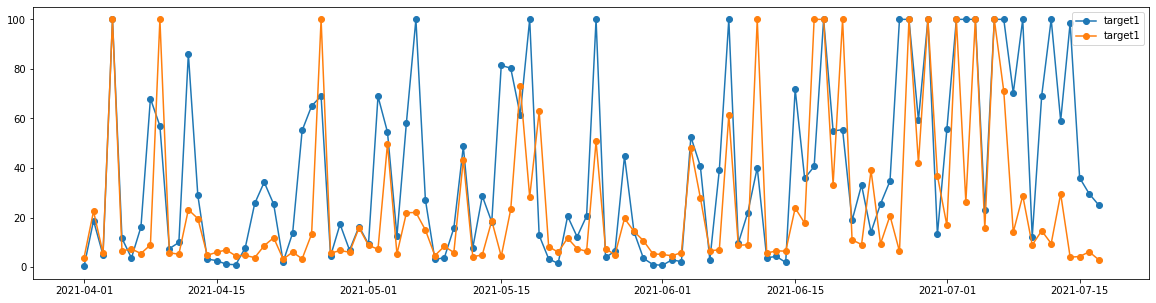

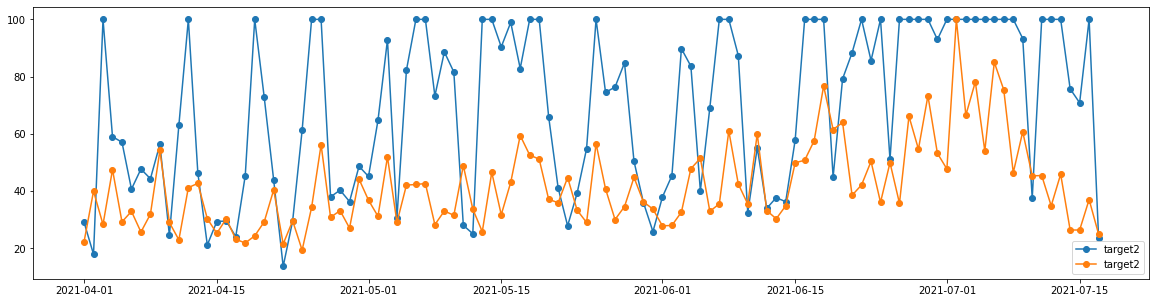

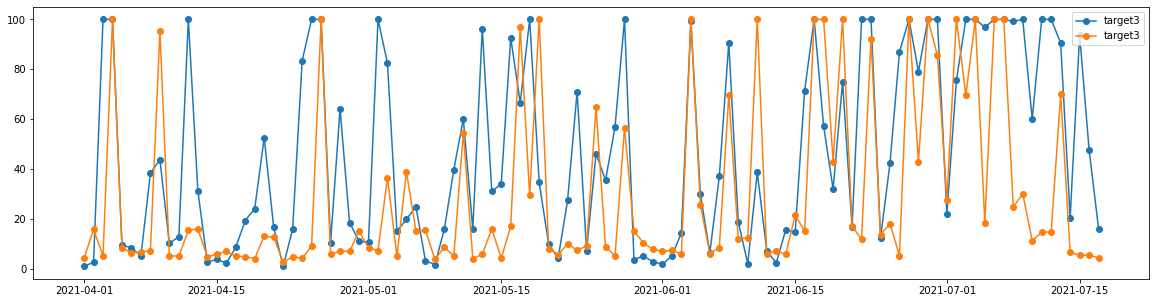

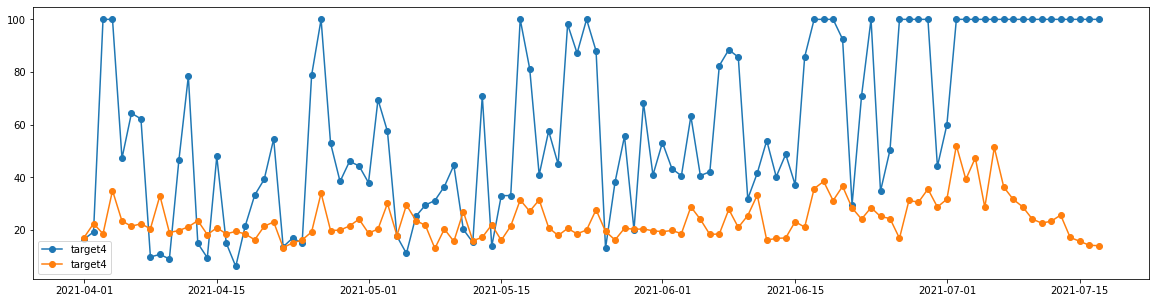

In [104]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [105]:
df[scaled_cols].min(), df[scaled_cols].max()

(target1__scaled    0.000000
 target2__scaled    0.018413
 target3__scaled    0.000000
 target4__scaled    0.016686
 dtype: float64,
 target1__scaled    2.043482
 target2__scaled    6.394876
 target3__scaled    1.965054
 target4__scaled    4.433660
 dtype: float64)

In [ ]:
MLBPowerTransformer(method='box-cox').fit_transform(df[['target2']]).max(axis=0)

In [ ]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [ ]:
fi_data = valid_data

In [ ]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [ ]:
all_features_list = list(features.columns)

In [ ]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

In [ ]:
fi_reg

In [ ]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [ ]:
output_path = 'prediction/drop_lstm'
os.makedirs(output_path, exist_ok=True)

In [ ]:
# valid_test_prediction.to_csv(os.path.join(output_path, 'april_to_jul.csv'), index=False)